In [25]:
# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv


from nb_functions import find_filtered_voronoi_neighbor_knn_limited_mask

In [26]:
positions = np.load('quarters/positions.npy')
print(positions.shape)

# load data

data = []
for i in range(4):
    for subpart in ["both", "BMP", "FGF"]:
        dat = np.load(f"quarters/quarter_{i}_{subpart}_SMAD_and_ERK.npy")
        dat = dat.swapaxes(1, 2)
        data.append(dat)


data = np.array(data)


(100, 2)


TODO:

Get data from the actual system of interest

PINN!

Encoding?

Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [71]:
class CustomGNN(torch.nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(CustomGNN, self).__init__()
        # check if list
        if type(hidden_dims) is not list:
            hidden_dims = [hidden_dims]
        
        # convolutional layer
        self.input_layer = GraphConv(input_dims, hidden_dims[0])

        self.hidden_layers = torch.nn.ModuleList()
        # Linear layers
        for i in range(len(hidden_dims)):
            _in = hidden_dims[i]
            _out = hidden_dims[i+1] if i+1 < len(hidden_dims) else hidden_dims[i]

            self.hidden_layers.append(Linear(_in, _out))


        self.output_layer = Linear(hidden_dims[-1], output_dims)


    def forward(self, feature_data, edge_info, edge_weights):


        # First Graph Convolutional layer (message passing)
        x = self.input_layer(feature_data, edge_info, edge_weights)
        x = F.relu(x)


        # Second GCN layer
        for layer in self.hidden_layers:
            x = layer(x)
            x = F.relu(x)


        x = self.output_layer(x, )
        # x = self.layer3(x, edge_info, edge_weights)
        # x = torch.tanh(x)

        
        return x
    
    

class Enviroment():
    def __init__(self):
        # load the data

        self.positions = positions

        self.ys = []       
        self.y_test = [] 

        for d in data:
            self.ys.append(torch.tensor(d, dtype=torch.float32))

        self.model = None
        self.optimizer = None

        self.early_stop_count = 0

        self.edges = None
        self.edge_weights = None

        

    def loss_fn(self, out, target):
        base_loss = F.mse_loss(out, target)
        
        weights_0 = self.model.input_layer.state_dict()['lin_root.weight'] + self.model.input_layer.state_dict()['lin_rel.weight']
        weights_1 = self.model.hidden_layers[0].weight
        
        l1_weights1 = F.mse_loss(weights_1, torch.zeros_like(weights_1))
        l1_weights0 = F.mse_loss(weights_0, torch.zeros_like(weights_0))
        return base_loss + 0.001*l1_weights1 + 0.001*l1_weights0
    

    def get_edges(self, positions):
        # create a graph with 1000 nodes
        # create a KD tree for fast nearest neighbor search
        # tree = KDTree(positions)
        # dists, indices = tree.query(positions, k=10)

        # indices[dists > 4.5] = -1

        indices, dists = find_filtered_voronoi_neighbor_knn_limited_mask(positions, 8,)
        print(indices.shape, dists.shape)
        # create adjacency matrix
        adj_matrix = np.zeros((100, 100))
        for i in range(100):
            for ji, j in enumerate(indices[i]):
                if j == -1:
                    continue
                adj_matrix[i, j] = dists[i, ji]
                adj_matrix[j, i] = dists[i, ji]

        # create edge data
        edges = torch.tensor(np.array(np.where(adj_matrix > 0)), dtype=torch.long).t().contiguous().T
        edge_weights = torch.tensor(adj_matrix[adj_matrix > 0], dtype=torch.float32)

        # make border array if less than 3 nbs
        border_mask =  torch.tensor(np.unique(edges, return_counts = True)[1] <= 4, dtype=torch.float32)

        return edges, edge_weights, border_mask

    def set_model(self, model):

        # from intel_npu_acceleration_library.compiler import CompilerConfig
        # compiler_conf = CompilerConfig(dtype=torch.float32, training=True)
        # compiled_model = intel_npu_acceleration_library.compile(model, compiler_conf)
        self.model = model

        self.optimizer = torch.optim.Adam(model.parameters(), lr=0.002)

    def call_model(self, X):
        if self.edges is None or self.edge_weights is None:
            self.edges, self.edge_weights, self.border_mask = self.get_edges(self.positions)
        
        X = torch.cat((X, self.border_mask.unsqueeze(1)), dim = 1)
        
        return self.model(X, self.edges, self.edge_weights)

    def transformation(self, X, target):
        angle = np.random.rand()*2*np.pi
        X = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in X])
        target = torch.tensor([[x[0]*np.cos(angle) - x[1]*np.sin(angle), x[0]*np.sin(angle) + x[1]*np.cos(angle)] for x in target])
        
        # scale = 0.5 + 1.5*np.random.rand()
        # X = X*scale
        # target = target*scale
        
        return X, target
    

    def check_early_stop(self, avg_loss, test_loss):
        if test_loss < avg_loss:
            self.early_stop_count = 0
            return False

        if self.early_stop_count >= 3:
            return True
        
        self.early_stop_count += 1
        return False
        



    def train(self, epochs):
        assert self.model is not None, "Model is not initialized"

        # train the model
        self.model.train()
        for epoch in range(1,epochs+1):
            loss = torch.tensor(0.0)
            avg_loss = torch.tensor(0.0)
            for yy in self.ys:
                n_steps = yy.shape[0] - 300
                for i in range(n_steps):
                    X = yy[i]

                    target = yy[i + 10]

                    # X, target = self.transformation(X, target)

                    self.optimizer.zero_grad()


                    out = self.call_model(X)

                    loss = self.loss_fn(out, target) 

                    loss.backward()
                    self.optimizer.step()
                    avg_loss += loss.item()
            
            avg_loss /= n_steps

            avg_loss = avg_loss.item()

            if epoch % 5 == 0:
                print(epoch)
                print(f"{epoch/epochs:.3} loss:", avg_loss)
                # test_loss = self.test()
                # if self.check_early_stop(avg_loss, test_loss):
                    # print('Early stoppping')
                    # break



# create a GNN model
model = CustomGNN(3, [4,], 2)

# create a training enviroment
env = Enviroment()

env.set_model(model)

env.train(1000)

(100, 8) (100, 8)
5
0.005 loss: 0.055113717913627625
10
0.01 loss: 0.09719172865152359
15
0.015 loss: 0.1413545310497284
20
0.02 loss: 0.18119370937347412
25
0.025 loss: 0.21791279315948486
30
0.03 loss: 0.2543991506099701
35
0.035 loss: 0.2876412272453308
40
0.04 loss: 0.3181527554988861
45
0.045 loss: 0.3468630611896515
50
0.05 loss: 0.3735424280166626
55
0.055 loss: 0.398762583732605
60
0.06 loss: 0.4225495159626007
65
0.065 loss: 0.446378231048584
70
0.07 loss: 0.4682271480560303
75
0.075 loss: 0.48804885149002075
80
0.08 loss: 0.5069040060043335
85
0.085 loss: 0.5256485342979431
90
0.09 loss: 0.5442350506782532
95
0.095 loss: 0.5602734684944153
100
0.1 loss: 0.5757061243057251
105
0.105 loss: 0.5897846817970276
110
0.11 loss: 0.5998998880386353
115
0.115 loss: 0.6051437258720398
120
0.12 loss: 0.6139338612556458
125
0.125 loss: 0.6223561763763428
130
0.13 loss: 0.6305384635925293
135
0.135 loss: 0.6376427412033081
140
0.14 loss: 0.6443789005279541
145
0.145 loss: 0.650736033916473

KeyboardInterrupt: 

torch.Size([1001, 100, 2])
(100, 8) (100, 8)


C:\Users\jakob\AppData\Local\Temp\ipykernel_20504\3317971592.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(y_val[iii], dtype=torch.float32)
C:\Users\jakob\AppData\Local\Temp\ipykernel_20504\3317971592.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(y_val[iii+10] , dtype=torch.float32)


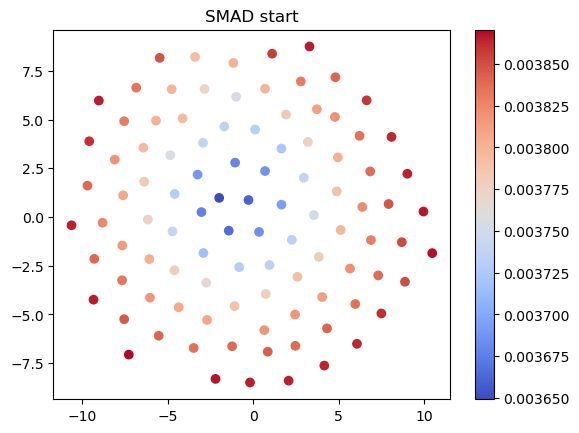

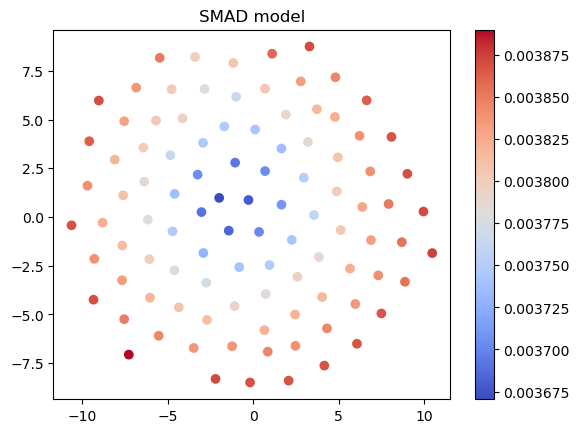

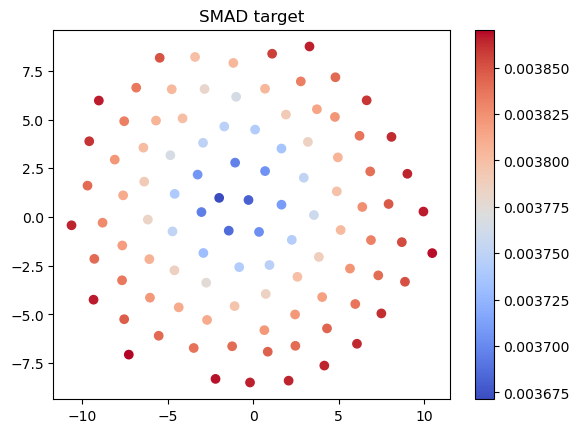

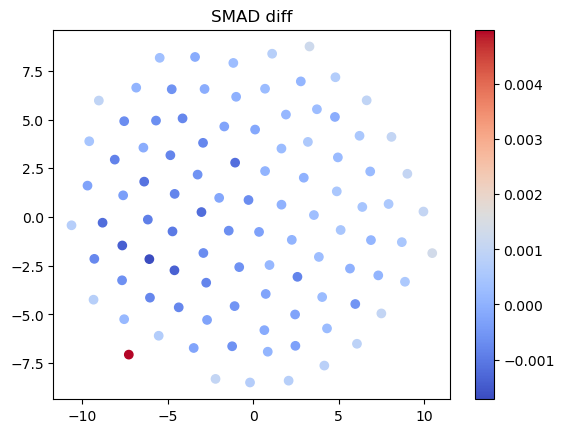

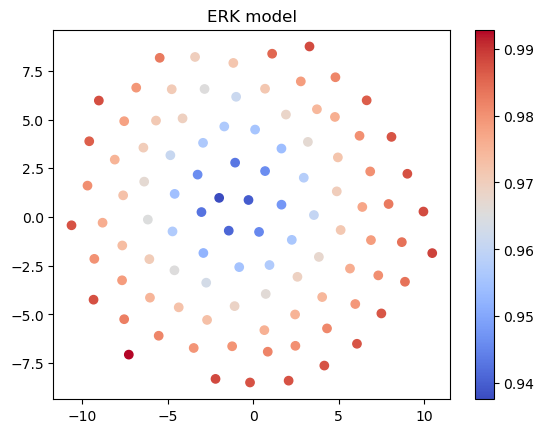

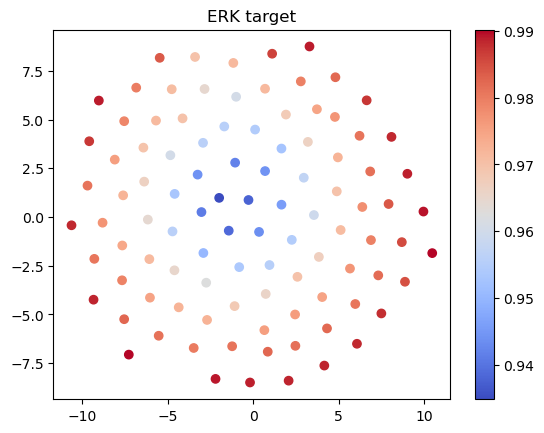

In [73]:
model.train(False)

# y_val = np.array([np.load(f'data/quarter_3_both.csv_BMP_levels.npy'), np.load(f'data/quarter_3_both.csv_FGF_levels.npy')])
y_val = env.ys[0]


iii  = 300
print(y_val.shape)
X = torch.tensor(y_val[iii], dtype=torch.float32)
target = torch.tensor(y_val[iii+10] , dtype=torch.float32)

edges, edge_weights, border = env.get_edges(env.positions)

X = torch.cat((X, border.unsqueeze(1)), dim = 1)

out = model(X, edges, edge_weights)

out = out.detach().numpy()


plt.scatter(env.positions[:,0], env.positions[:,1], c=X[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD start')
plt.show()

plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD model')
plt.show()


plt.scatter(env.positions[:,0], env.positions[:,1], c=target[:,0], cmap='coolwarm')
plt.colorbar()
plt.title('SMAD target')
plt.show()

# plot diff

plt.scatter(env.positions[:,0], env.positions[:,1], c=(out[:,0] - target[:,0].detach().numpy())/target[:,0].detach().numpy(), cmap='coolwarm')
plt.colorbar()
plt.title('SMAD diff')
plt.show()



plt.scatter(env.positions[:,0], env.positions[:,1], c=out[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('ERK model')
plt.show()


plt.scatter(env.positions[:,0], env.positions[:,1], c=target[:,1], cmap='coolwarm')
plt.colorbar()
plt.title('ERK target')
plt.show()



In [53]:
parameters_to_prune = []

for layer in model.modules():
    if hasattr(layer, 'weight'):
        parameters_to_prune.append((layer, 'weight'))

from torch.nn.utils import prune
prune.global_unstructured(
    parameters_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.2,
)

parameters_to_prune



[(Linear(3, 4, bias=True), 'weight'),
 (Linear(3, 4, bias=False), 'weight'),
 (Linear(4, 4, bias=True), 'weight'),
 (Linear(4, 2, bias=True), 'weight')]

<bound method Module.parameters of CustomGNN(
  (input_layer): GraphConv(3, 4)
  (hidden_layers): ModuleList(
    (0): Linear(4, 4, bias=True)
  )
  (output_layer): Linear(4, 2, bias=True)
)>
<bound method Module.parameters of GraphConv(3, 4)>
<bound method Module.parameters of SumAggregation()>
<bound method Module.parameters of Linear(3, 4, bias=True)>


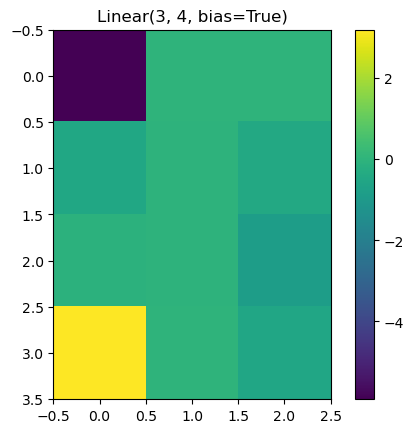

<bound method Module.parameters of Linear(3, 4, bias=False)>


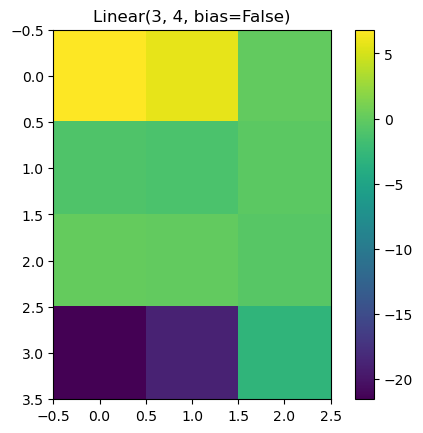

<bound method Module.parameters of ModuleList(
  (0): Linear(4, 4, bias=True)
)>
<bound method Module.parameters of Linear(4, 4, bias=True)>


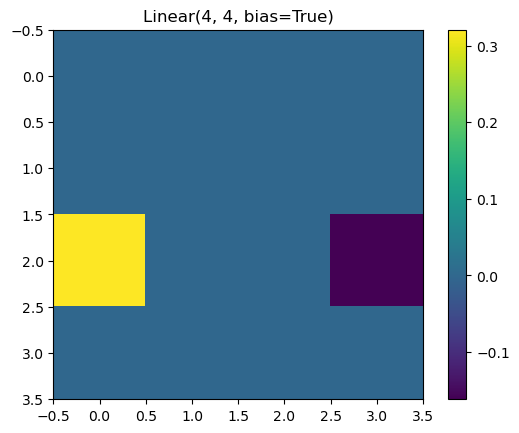

<bound method Module.parameters of Linear(4, 2, bias=True)>


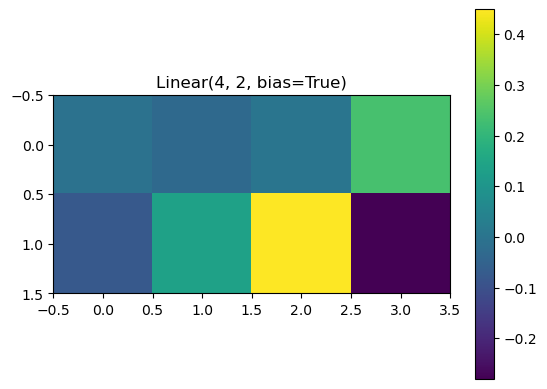

In [74]:
for layer in model.modules():
    print(layer.parameters)
    if not hasattr(layer, 'weight'):
        continue
    plt.imshow(layer.weight.detach().numpy())
    
    # mask = ~list(layer.named_buffers())[0][1].detach().numpy().astype(bool)
    # plt.scatter(np.where(mask)[1], np.where(mask)[0], c='r')
    plt.title(layer)
    plt.colorbar()
    plt.show()